Pretrained model link to Google Drive: https://drive.google.com/file/d/1Z0oIc3lc7VFNDclUnOTma2eZg4UTJmBg/view?usp=sharing

Import libs





In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation,\
                                    MaxPool2D, UpSampling2D, concatenate,\
                                    Input, Conv2DTranspose, MaxPooling2D,\
                                    Dropout, BatchNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import PIL
from matplotlib import colors

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.image

Utils

In [2]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, sublayers=2):
    '''In case batchnorm=False "if" statement will be skipped and in amount of "sublayers" convolutional layers will be created.'''
    for idx in range(sublayers):
        conv = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
                   kernel_initializer="he_normal", padding="same")(input_tensor if idx==0 else conv)
        if batchnorm:
            normalized = BatchNormalization()(conv)
        conv = Activation("relu")(conv) # normalized to conv
    return conv

def conv2d_transpose_block(input_tensor, concatenate_tensor, n_filters, kernel_size=3, strides=2, transpose=False):
    if transpose:
        conv = Conv2DTranspose(n_filters, (kernel_size, kernel_size),
                               strides=(strides, strides), padding='same')(input_tensor)
    else:
        conv = Conv2D(n_filters, (kernel_size, kernel_size), activation = 'relu', padding = 'same',
                      kernel_initializer = 'he_normal')(UpSampling2D(size=(kernel_size, kernel_size))(input_tensor))
    conv = Activation("relu")(conv)
    concatenation = concatenate([conv, concatenate_tensor])
    return concatenation

def build_unet(input_shape=(512, 512, 3), filters=[16, 32, 64, 128, 256], batchnorm=True, transpose=False, dropout_flag=False):  # dropout_rate=0.2

    conv_dict = dict()
    inputs = Input(input_shape)
    dropout_rate = 0.5

    for idx, n_filters in enumerate(filters[:-1]):
        conv = conv2d_block(inputs if n_filters==filters[0] else max_pool, # Change max_pool to dropout
                            n_filters=n_filters, kernel_size=3,
                            batchnorm=batchnorm)
        max_pool = MaxPooling2D((2, 2))(conv)
        # Save layer
        conv_dict[f"conv2d_{idx+1}"] = conv

    # Change max_pool to dropout
    conv_middle = conv2d_block(max_pool, n_filters=filters[-1], kernel_size=3, batchnorm=batchnorm)

    for idx, n_filters in enumerate(reversed(filters[:-1])):
        concatenation = conv2d_transpose_block(conv_middle if idx==0 else conv,
                                               conv_dict[f"conv2d_{len(conv_dict) - idx}"],
                                               n_filters, kernel_size=2, strides=2, transpose=transpose) # kernel_size=2, like in previous

        conv = conv2d_block(concatenation, n_filters=n_filters, kernel_size=3, # Change concatenation to Dropout
                              batchnorm = batchnorm)
        print(f'[INFO] UpConv block {idx} created.')
    outputs = Conv2D(3, (1, 1), activation='softmax')(conv)
    model = Model(inputs=inputs, outputs=outputs)
    return model

Parse data


In [3]:
def get_example(dataset_path, image_num):
  raw_image_dataset = tf.data.TFRecordDataset(dataset_path)
  # Create a dictionary describing the features.
  image_feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
  }

  def _parse_image_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

  parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
  for image_features in parsed_image_dataset:
    if image_num != 0:
      image_raw = image_features['image'].numpy()
      mask_raw = image_features['mask'].numpy()
      image_num -= 1
    else:
      break
  image = tf.image.decode_png(image_raw, channels=3)
  image = tf.image.resize(image, [512, 512])
  image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
  mask = tf.io.decode_raw(mask_raw, out_type="float")
  mask = tf.reshape(mask, [512, 512, 3])
  mask = tf.cast(mask, tf.float32)
  return image, mask

In [4]:
model = build_unet(input_shape=(512, 512, 3),
                   filters=[2 ** i for i in range(5, int(np.log2(2048) + 1))],
                   batchnorm=False, transpose=False, dropout_flag=False)

[INFO] UpConv block 0 created.
[INFO] UpConv block 1 created.
[INFO] UpConv block 2 created.
[INFO] UpConv block 3 created.
[INFO] UpConv block 4 created.
[INFO] UpConv block 5 created.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path_to_load = "/content/drive/MyDrive/datasets/U6_E 1201-F1 0.7134-IOU 0.6555.h5"
model.load_weights(path_to_load)

In [8]:
path_to_image = "/content/drive/MyDrive/datasets/image.png"
image = tf.io.read_file(path_to_image)
image = tf.io.decode_png(image)
# image_1, mask = get_example("/content/drive/MyDrive/datasets/tfrecords_v2_part_1.tfrec", 2) # for one more pictures

In [9]:
image = image[np.newaxis, ...]
prediction = model.predict(image)
prediction_class1 = np.copy(prediction[..., 0]) # Forest
prediction_class2 = np.copy(prediction[..., 1]) # Deforest
prediction[..., 0] = prediction_class2 # RED - Deforest
prediction[..., 1] = prediction_class1 # GREEN - Forest

1/1 [==============================] - 4s 4s/step


Save to disk

In [18]:
save_path = "/content/name.png"
matplotlib.image.imsave(save_path, prediction[0])

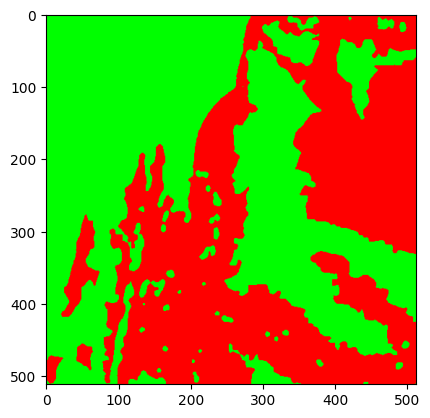

In [13]:
plt.imshow(prediction[0])